# SDM 274

Author: Ziyuan Li, 12211225

Using a k-NN to predict diagnosis on the Wisconsin Cancer dataset.


# 1. Preparing the data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial import KDTree
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Load the data
data = pd.read_csv('wdbc.data', header=None)

# Split the data into features and labels
X = data.iloc[:, 2:].values
Y = data.iloc[:, 1].values
Y = Y.reshape(-1,1)

print('X shape:', X.shape)
print('Y shape', Y.shape)

print("The first Diagnosis is: ", Y[0])
print("The first 5 features are: ", X[0][:5])

X shape: (569, 30)
Y shape (569, 1)
The first Diagnosis is:  ['M']
The first 5 features are:  [1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01]


As we can see from the example data, the values of the dataset varies in magnitude pretty much. As we will shown below, k-NN algorithm is capable of solving classification problem like this, with varying magnitude and high dimension. However we do not discuss the boundary of k-NN here by challenging it with extremely disperse data.

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Here we split the dataset into a training dataset and a test dataset, by 0.7 and 0.3.

We specify the random state to make the result reproducible.

# 2. Defining the class


In [3]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        self.kdtree = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.kdtree = KDTree(X)

    def _predict(self, x):
        """Predicting label from single sample"""

        dist, idx = self.kdtree.query(x, k=self.k, p=2)
        if idx.ndim == 0 or idx.ndim == 1:
            idx = idx.reshape(1, -1)
        neighbors_labels = [self.y_train[i].item() for i in idx[0]]

        prediction = max(set(neighbors_labels), key=neighbors_labels.count)
        return prediction
    
    def predict(self, X):
        """Predicting labels from multiple samples"""
        y_pred = [self._predict(x) for x in X]
        return y_pred


    

The core of the KNN class is finding nearest points, and using a KD tree structure to optimize the finding process.

Mathematically, what it does is splits the dataset by the median on a dimension, and does it recursively for every dimension. Spatially it divides the whole space in two splits on every dimension, thus simplifying the search process.



# 3. Do the training


In [4]:
knn = KNN(k=3)
knn.fit(X_train, y_train)

In [5]:

y_pred = knn.predict(X_test)
# print("Result:" , y_pred)
def calculate_accuracy(y_actual, y_pred):

    correct_predictions = 0
    total_predictions = len(y_actual) # total number of predictions, actually a cache

    for i in range(total_predictions):
        if y_actual[i] == y_pred[i]:
            correct_predictions += 1

    return correct_predictions / total_predictions

def calculate_recall(y_actual, y_pred, positive_label='M'):
    true_positive = 0
    false_negative = 0

    for i in range(len(y_actual)):
        if y_actual[i] == positive_label:
            if y_pred[i] == positive_label:
                true_positive += 1
            else:
                false_negative += 1

    recall = true_positive / (true_positive + false_negative)
    return recall

def calculate_precision(y_actual, y_pred, positive_label='M'):
    true_positive = 0
    false_positive = 0

    for i in range(len(y_actual)):
        if y_pred[i] == positive_label:
            if y_actual[i] == positive_label:
                true_positive += 1
            else:
                false_positive += 1

    precision = true_positive / (true_positive + false_positive)
    return precision

def calculate_f1_score(y_actual, y_pred, positive_label='M'):
    precision = calculate_precision(y_actual, y_pred, positive_label)
    recall = calculate_recall(y_actual, y_pred, positive_label)

    f1_score = 2 * precision * recall / (precision + recall)
    return f1_score


accuracy = calculate_accuracy(y_test, y_pred)
recall = calculate_recall(y_test, y_pred, 'M')
precision = calculate_precision(y_test, y_pred, 'M')
f1_score = calculate_f1_score(y_test, y_pred, 'M')



This task is also a binary classification task that we can use the four metrics used in former assignments to evaluate the performance of the model.

In [6]:

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1_score}')

Accuracy: 0.9415204678362573
Recall: 0.9047619047619048
Precision: 0.9344262295081968
F1 Score: 0.9193548387096775


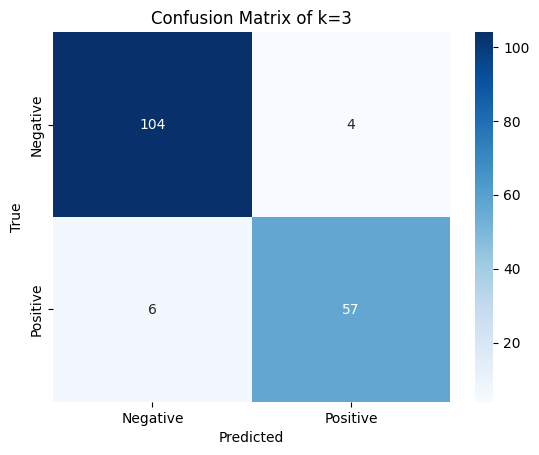

In [7]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of k=3")
plt.show()


Here we use a confusion matrix to visualize the data, which can be more accurate compared with plotting the predicted points and the true points together.

Because there is not a "threshold" here - we decide by majority voting instead of a probability, therefore ROC curve do not directly apply here. 
ALthough we can actually consider the ratio of points as a form of probability, it can bring wrong estimations when k is small according to the law of large numbers.

# 4. Discussing different values of k in k-NN

Here we choose a list of different k values to investigate the effect of this hyperparam on the classification.
As specified by the professor we use k's from 1 to 10.

The training is very simple when compared with gradient-descent based approaches. Actually the fitting process is only taking a KD tree of all training data, instead of gradually minimizing a "test error". In other words, there is only one hyperparam in the whole model, that is, the k value. Therefore we can conveniently change the k value to evaluate its impact of the algorithm. 

In [8]:
k_list = np.arange(1,11)
KNN_eval = KNN(k=1)
KNN_eval.fit(X_train, y_train)

prediction_array = []
metrics_array = []

for k in k_list:
    KNN_eval.k = k
    prediction = KNN_eval.predict(X_test)
    prediction_array.append(prediction)
    metrics_array.append([calculate_accuracy(y_test, prediction), calculate_recall(y_test, prediction, 'M'), calculate_precision(y_test, prediction, 'M'), calculate_f1_score(y_test, prediction, 'M')])


We create a model and let it predict the results for differen k values ranging from 1 to 10.

In [9]:
# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame(metrics_array, columns=['Accuracy', 'Recall', 'Precision', 'F1 Score'], index=k_list)

# Display the DataFrame
print(metrics_df)

    Accuracy    Recall  Precision  F1 Score
1   0.935673  0.888889   0.933333  0.910569
2   0.941520  0.857143   0.981818  0.915254
3   0.941520  0.904762   0.934426  0.919355
4   0.953216  0.873016   1.000000  0.932203
5   0.959064  0.904762   0.982759  0.942149
6   0.953216  0.888889   0.982456  0.933333
7   0.964912  0.936508   0.967213  0.951613
8   0.964912  0.920635   0.983051  0.950820
9   0.970760  0.936508   0.983333  0.959350
10  0.959064  0.904762   0.982759  0.942149


We calculate the four metrics for every k value.

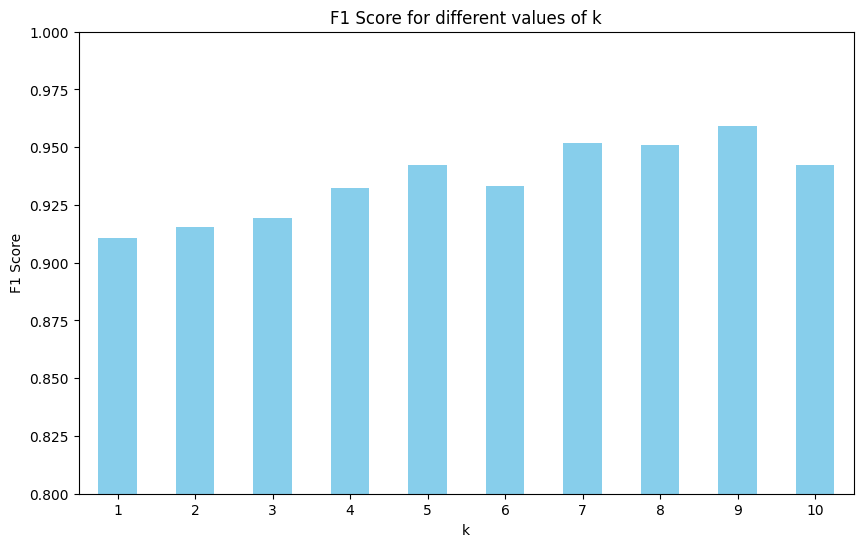

In [10]:
metrics_df['F1 Score'].plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score for different values of k')
plt.ylim([0.8, 1])
plt.xticks(rotation=0)
plt.show()

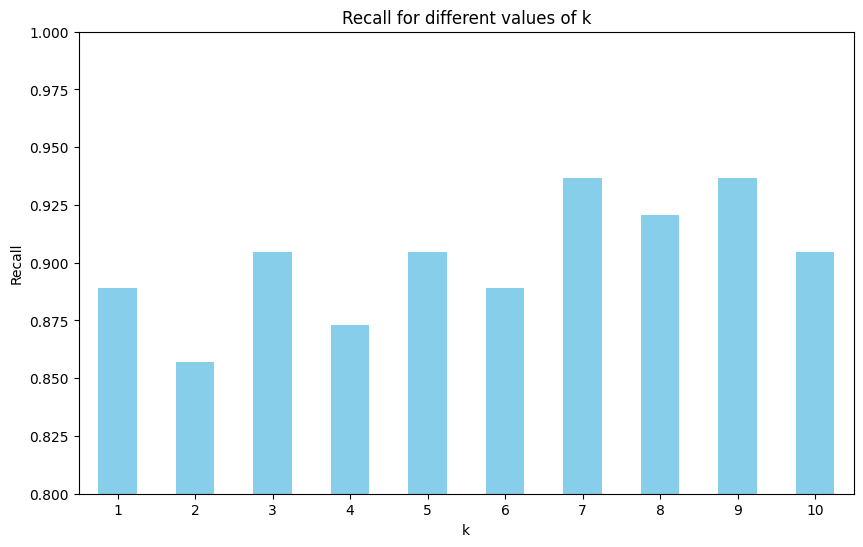

In [11]:
metrics_df['Recall'].plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('Recall for different values of k')
plt.ylim([0.8, 1])
plt.xticks(rotation=0)
plt.show()


In [ ]:
max_f1_score_row = metrics_df.loc[metrics_df['F1 Score'].idxmax()]
print(max_f1_score_row)
print()
max_recall_row = metrics_df.loc[metrics_df['Recall'].idxmax()]
print(max_recall_row)

Accuracy     0.970760
Recall       0.936508
Precision    0.983333
F1 Score     0.959350
Name: 9, dtype: float64

Accuracy     0.964912
Recall       0.936508
Precision    0.967213
F1 Score     0.951613
Name: 7, dtype: float64



Above graphs and tables visualize the influence of different k values.

The F1 score generally increases with the increase of k value, and peaks at about k = 9. 

However, when considering diagnosis of a cancer, we  will often consider the value of recall over precision because the negative impact of a false negative is much higher than a false positive. In this case, hyperparameter k = 7 produced the highest recall.

Generally this can be explained by using more nearby points lowers the possibility of outliers interfering the result. In other words, higher k means a beneficially wider scope when doing the classification. However using too high k value could also bring down the performance, as an example see the decrease of the f1 score in k = 10. Or theoretically when we take k ~= infty the classification will become meaningless. 